In [1]:
import numpy as np
import struct
import seaborn as sns
import pandas as pd
from array import array
from os.path  import join
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as p

In [2]:
in_path = './archive'
train_images = join(in_path, 
    'train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = join(in_path,
    'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = join(in_path, 
    't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = join(in_path, 
    't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [3]:
# Defining a class for loading and processing the MNIST dataset
class MnistDataloader(object):
    def __init__(self, training_images, training_labels, test_images, test_labels):
        self.training_images = training_images
        self.training_labels = training_labels
        self.test_images = test_images
        self.test_labels = test_labels
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        # Read and process label data
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            labels = array("B", file.read())
        # Read and process image data        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        
        return images, labels

    def load_data(self):
        # Load training and testing data
        x_train, y_train = self.read_images_labels(self.training_images, self.training_labels)
        x_test, y_test = self.read_images_labels(self.test_images, self.test_labels)
        return (x_train, y_train),(x_test, y_test)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, dims):
        super(AutoEncoder, self).__init__()
        self.dims = dims

        # Encoder
        encoder_layers = []
        for i in range(len(dims)//2):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)//2 - 1:
                encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        for i in range(len(dims)//2, len(dims)-1):
            decoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, encoded):
        return self.decoder(encoded)

In [5]:
def train(model, train_loader, epochs=5, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    train_costs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            # Forward pass
            output = model(data)
            loss = criterion(output, data)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_costs.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return train_costs

# Function to calculate the sum of diagonal elements in a confusion matrix
def getSum(cm):
    sum = 0
    for i in range(10):
        sum += cm[i][i]
    return sum

In [6]:
# Loading the MNIST dataset
mndl = MnistDataloader(train_images, train_labels, test_images, test_labels)
(x_train, y_train), (x_test, y_test) = mndl.load_data()

# Preprocessing the dataset
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

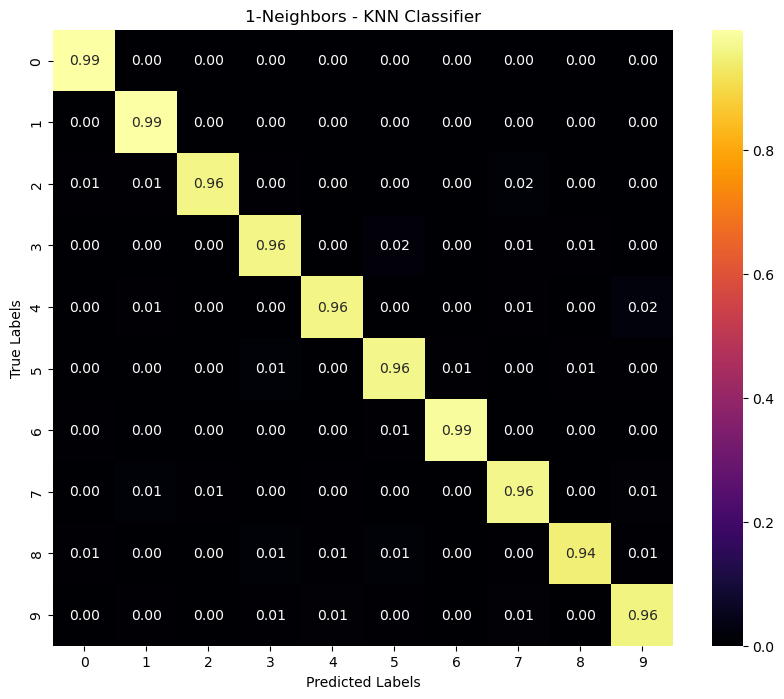

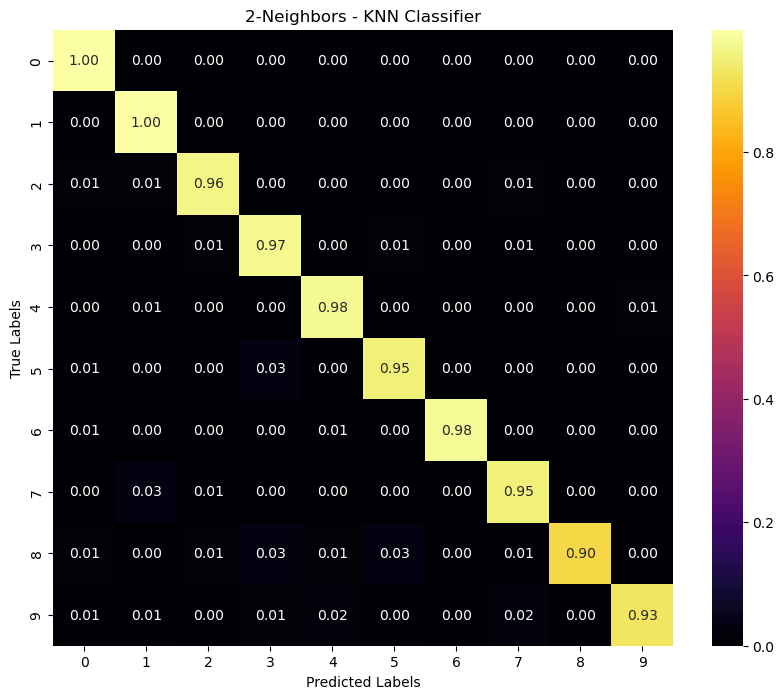

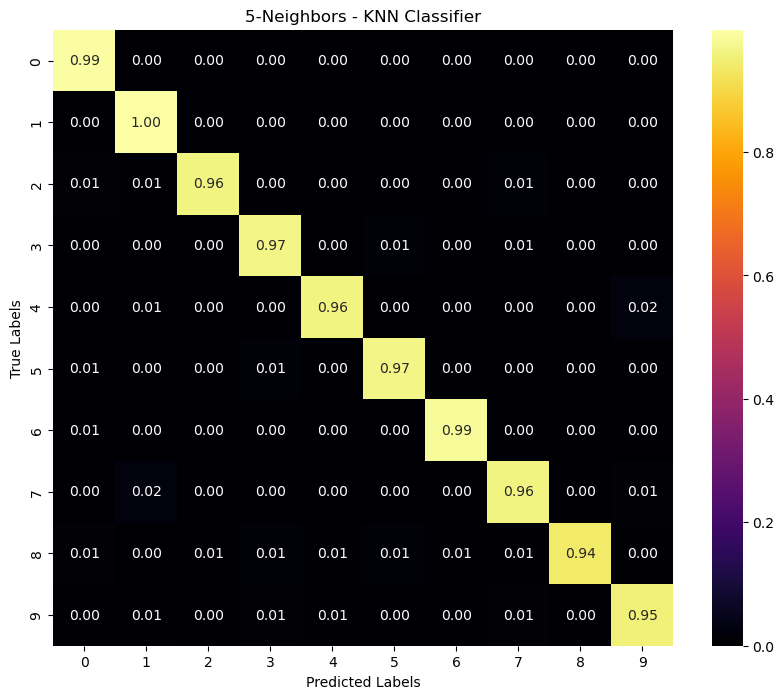

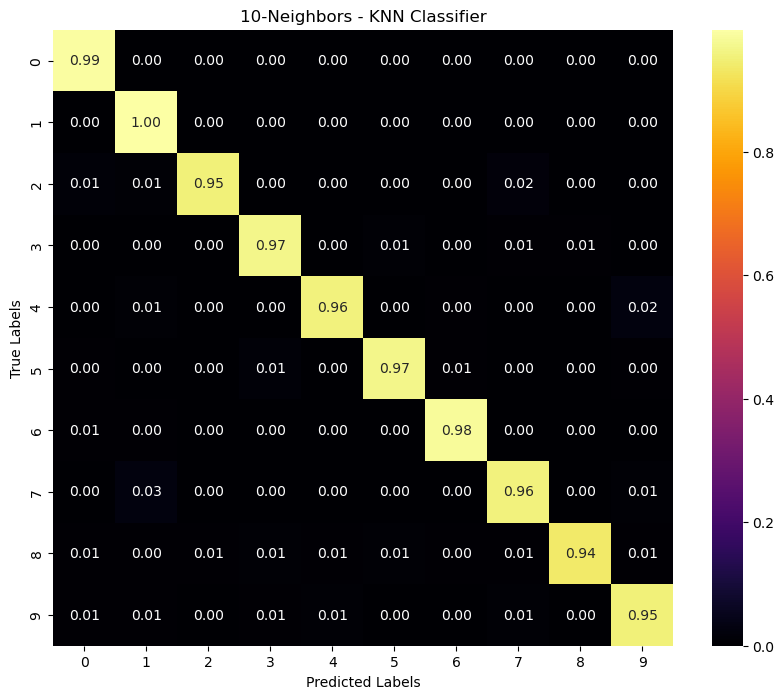

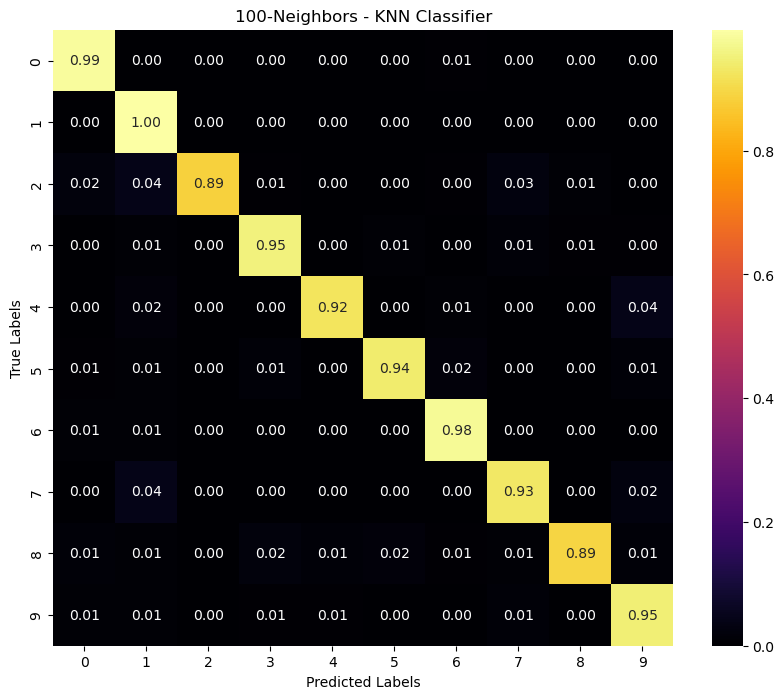

,k,Accuracy,Test Error
0,1,0.9691,0.0309
1,2,0.9627,0.0373
2,5,0.9688,0.0312
3,10,0.9665,0.0335
4,100,0.9440,0.0560


In [7]:
# List of k values
k_neighbors = [1, 2, 5, 10, 100]

# Lists to store results
k_values = []
accuracy_list = []
error_list = []

# Loop over the different k values
for k in k_neighbors:
    # Train the K-Nearest Neighbors Classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)

    # Predict on test set
    pred_y = knn.predict(x_test)

    # Calculate accuracy and test error
    accuracy = np.mean(pred_y == y_test)
    test_error = 1 - accuracy

    # Append results to lists
    k_values.append(k)
    accuracy_list.append(accuracy)
    error_list.append(test_error)

    # Calculate the normalized confusion matrix
    cm = confusion_matrix(y_test, pred_y)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="inferno")
    plt.title(f'{k}-Neighbors - KNN Classifier')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Create a DataFrame
results_df = pd.DataFrame({
    'k': k_values,
    'Accuracy': accuracy_list,
    'Test Error': error_list
})

# Display the DataFrame
results_df

In [8]:
# Apply PCA to reduce dimensions to 2
pca = decomposition.PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

<Figure size 1200x800 with 0 Axes>

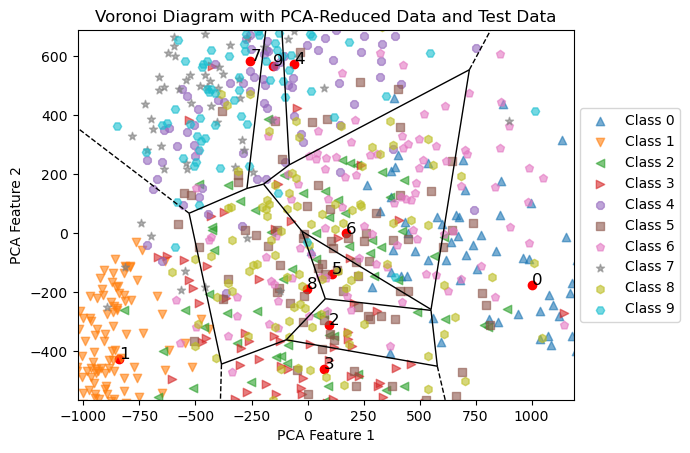

In [9]:
# Compute centroids
centroids = []
for i in range(10):
    centroids.append(np.mean(x_train_pca[y_train == i], axis=0))

# Create Voronoi diagram
vor = Voronoi(centroids)

# Plot Voronoi diagram
plt.figure(figsize=(12, 8))
voronoi_plot_2d(vor, show_vertices=False, show_points=False)
for centroid, label in zip(centroids, range(10)):
    plt.scatter(centroid[0], centroid[1], marker='o', color='r')
    plt.text(centroid[0], centroid[1], str(label), color='black', fontsize=12)

# Plot a random subset of test data with different markers
subset_size = 1000
indices = random.sample(range(len(x_test_pca)), subset_size)
markers = ['^', 'v', '<', '>', '8', 's', 'p', '*', 'h', 'H']

for i, marker in zip(range(10), markers):
    class_indices = [index for index in indices if y_test[index] == i]
    plt.scatter(x_test_pca[class_indices, 0], x_test_pca[class_indices, 1], marker=marker, alpha=0.6, label=f'Class {i}')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Voronoi Diagram with PCA-Reduced Data and Test Data")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

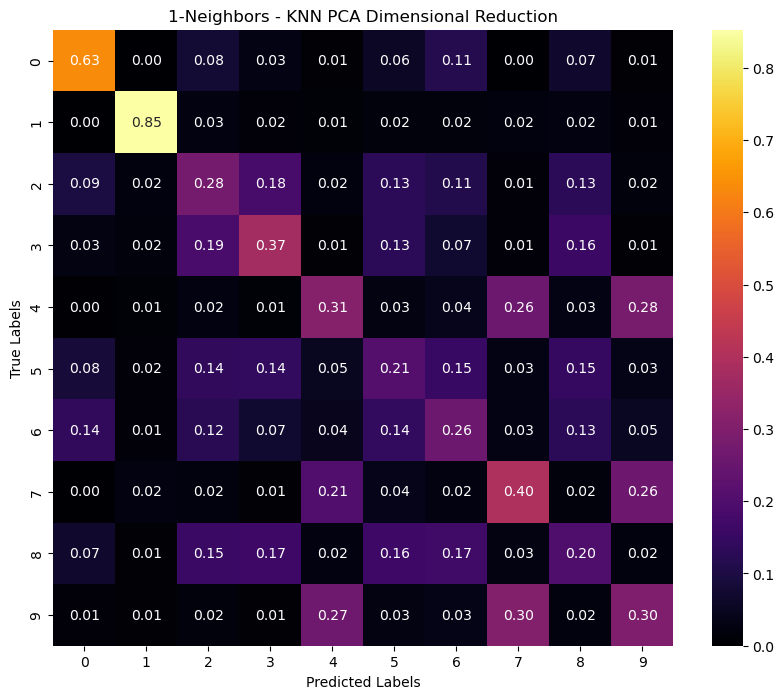

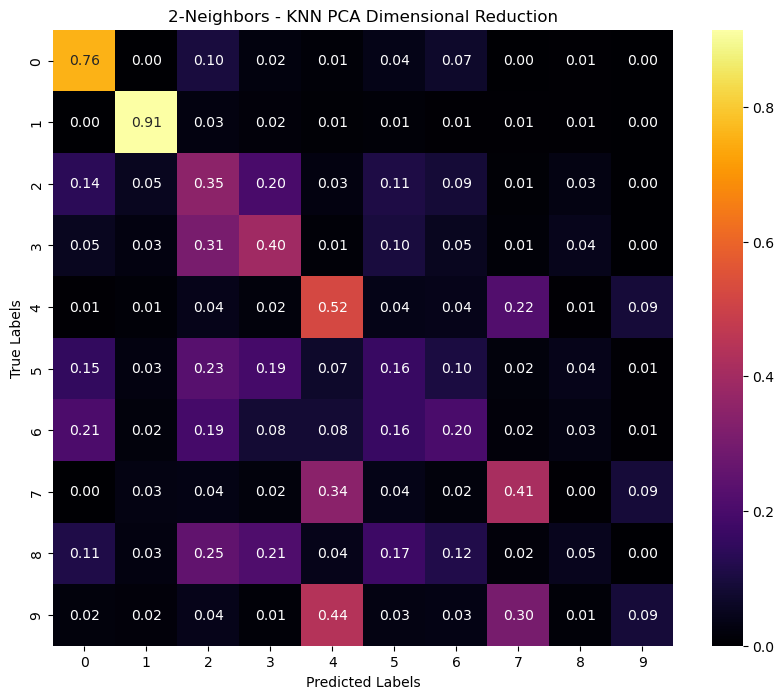

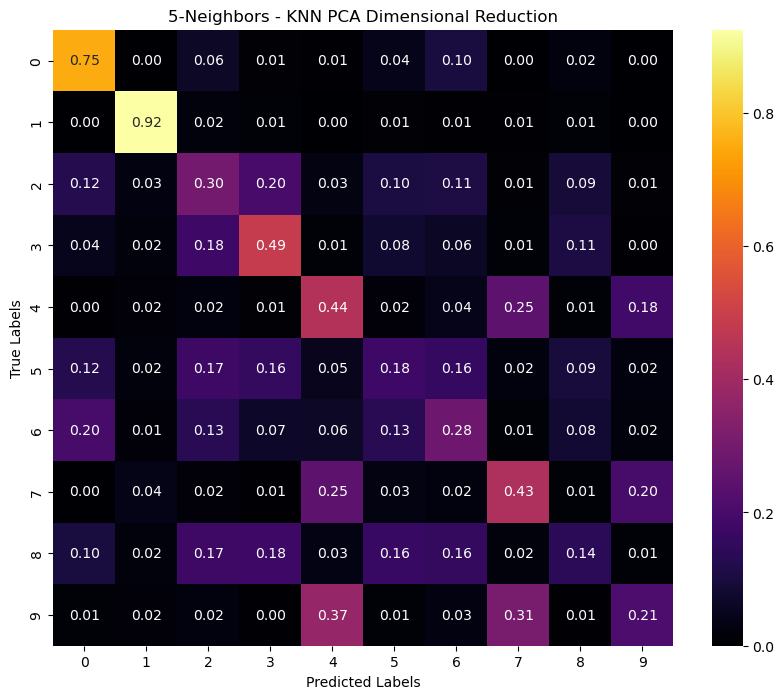

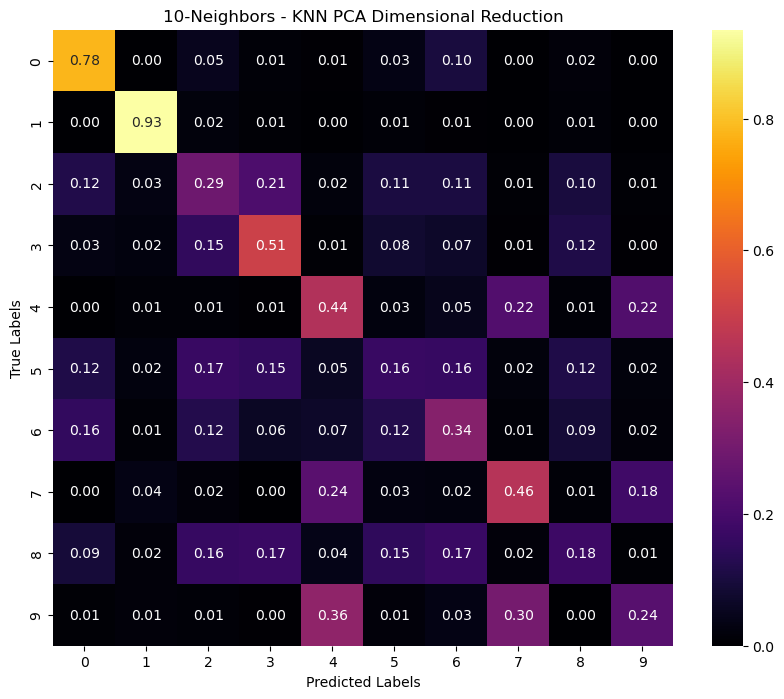

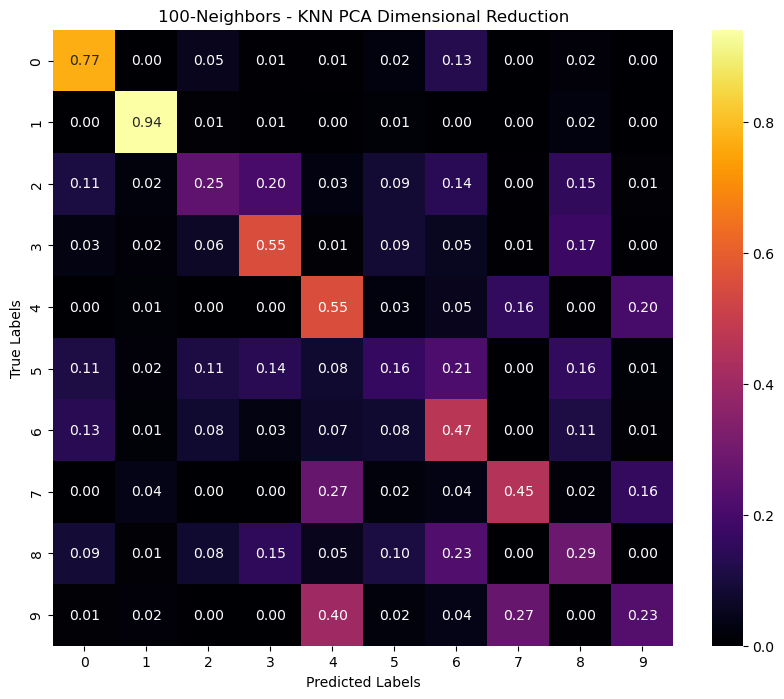

,k,Accuracy,Test Error
0,1,0.3897,0.6103
1,2,0.3957,0.6043
2,5,0.4243,0.5757
3,10,0.4422,0.5578
4,100,0.4759,0.5241


In [10]:
k_neighbors = [1, 2, 5, 10, 100]
k_values = []
accuracy_list = []
error_list = []

for k in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    pred_y = knn.predict(x_test_pca)

    # Calculate accuracy and test error
    accuracy = np.mean(pred_y == y_test)
    test_error = 1 - accuracy

    # append values to lists
    k_values.append(k)
    accuracy_list.append(accuracy)
    error_list.append(test_error)

    # Calculate the normalized confusion matrix
    cm = confusion_matrix(y_test, pred_y)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="inferno")
    plt.title(f'{k}-Neighbors - KNN PCA Dimensional Reduction')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# turn results to DF
results_df = pd.DataFrame({
    'k': k_values,
    'Accuracy': accuracy_list,
    'Test Error': error_list
})

results_df

In [11]:
# Assuming AutoEncoder class is already defined as per your initial code
autoencoder = AutoEncoder([784, 300, 100, 2, 100, 300, 784])

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the AutoEncoder
train_costs = train(autoencoder, train_loader, epochs=5)

# Apply the Autoencoder to reduce dimensions
x_train_ae = autoencoder.encode(x_train_tensor).detach().numpy()
x_test_ae = autoencoder.encode(x_test_tensor).detach().numpy()

Epoch [1/5], Loss: 3400.1611
Epoch [2/5], Loss: 2996.0086
Epoch [3/5], Loss: 2898.5050
Epoch [4/5], Loss: 2840.1871
Epoch [5/5], Loss: 2800.9242


<Figure size 1200x800 with 0 Axes>

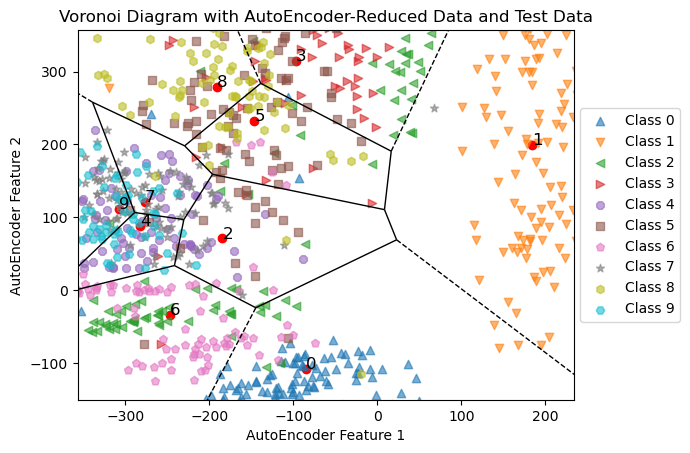

In [12]:
# Compute centroids from the autoencoder-reduced training data
centroids_ae = []
for i in range(10):
    centroids_ae.append(np.mean(x_train_ae[y_train == i], axis=0))

# Create a Voronoi diagram based on these centroids
vor_ae = Voronoi(centroids_ae)

# Plot the Voronoi diagram
plt.figure(figsize=(12, 8))
voronoi_plot_2d(vor_ae, show_vertices=False, show_points=False)

# Plot each centroid and annotate it with the corresponding digit label
for centroid, label in zip(centroids_ae, range(10)):
    plt.scatter(centroid[0], centroid[1], marker='o', color='red')
    plt.text(centroid[0], centroid[1], str(label), color='black', fontsize=12)

# Plot a random subset of autoencoder-reduced test data
subset_size = 1000
indices = random.sample(range(len(x_test_ae)), subset_size)
markers = ['^', 'v', '<', '>', '8', 's', 'p', '*', 'h', 'H']

for i, marker in zip(range(10), markers):
    class_indices = [index for index in indices if y_test[index] == i]
    plt.scatter(x_test_ae[class_indices, 0], x_test_ae[class_indices, 1], marker=marker, alpha=0.6, label=f'Class {i}')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Voronoi Diagram with AutoEncoder-Reduced Data and Test Data")
plt.xlabel("AutoEncoder Feature 1")
plt.ylabel("AutoEncoder Feature 2")
plt.show()

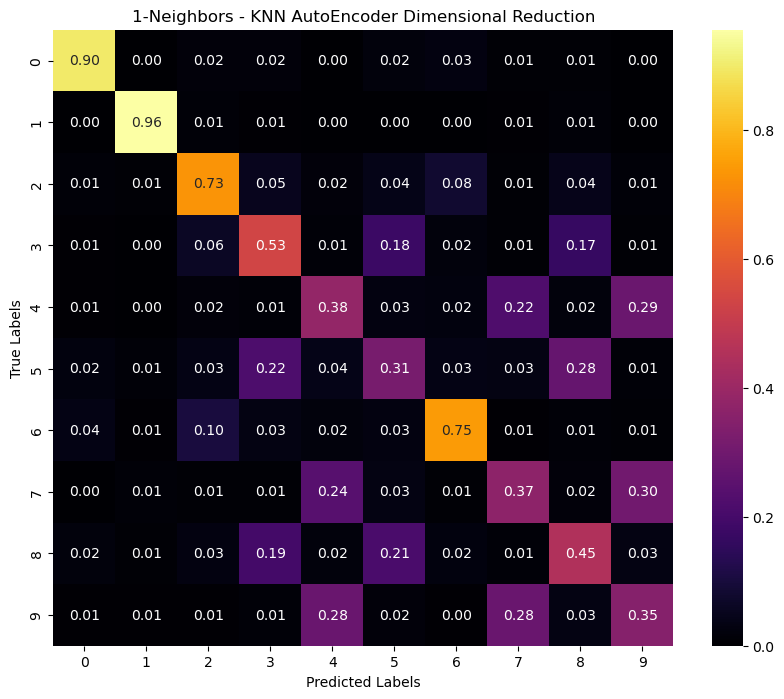

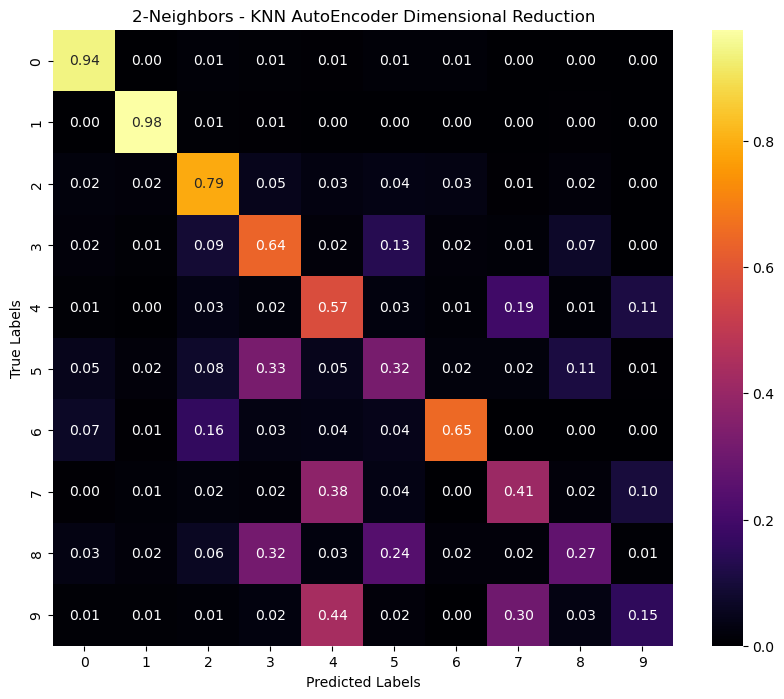

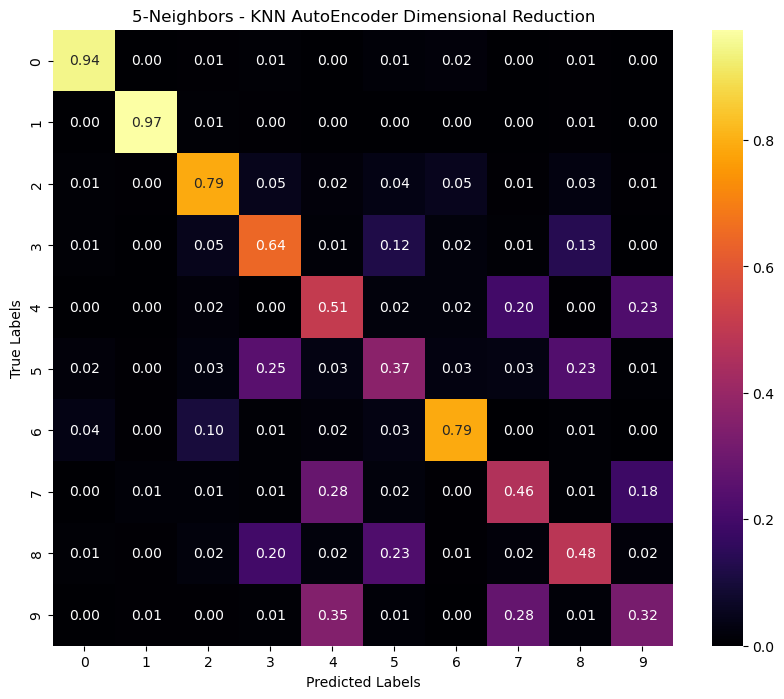

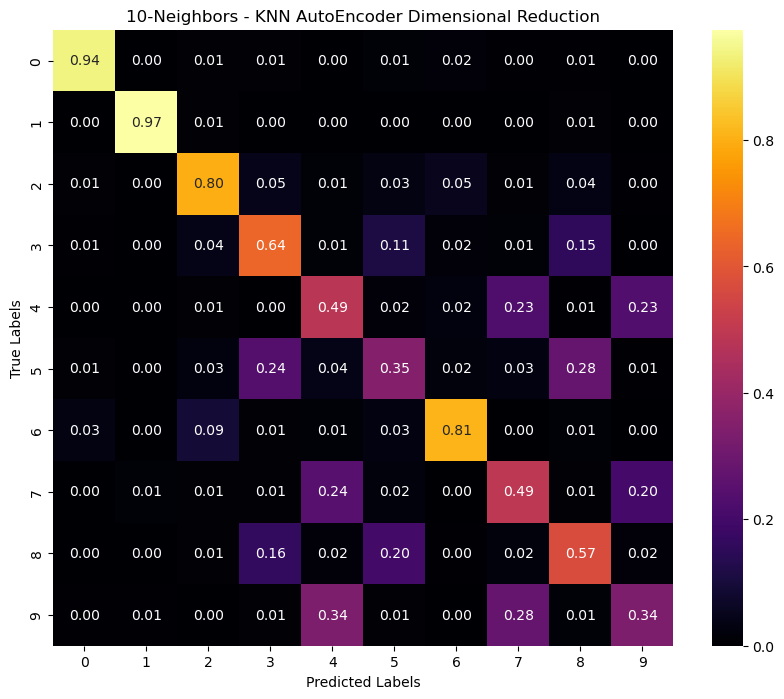

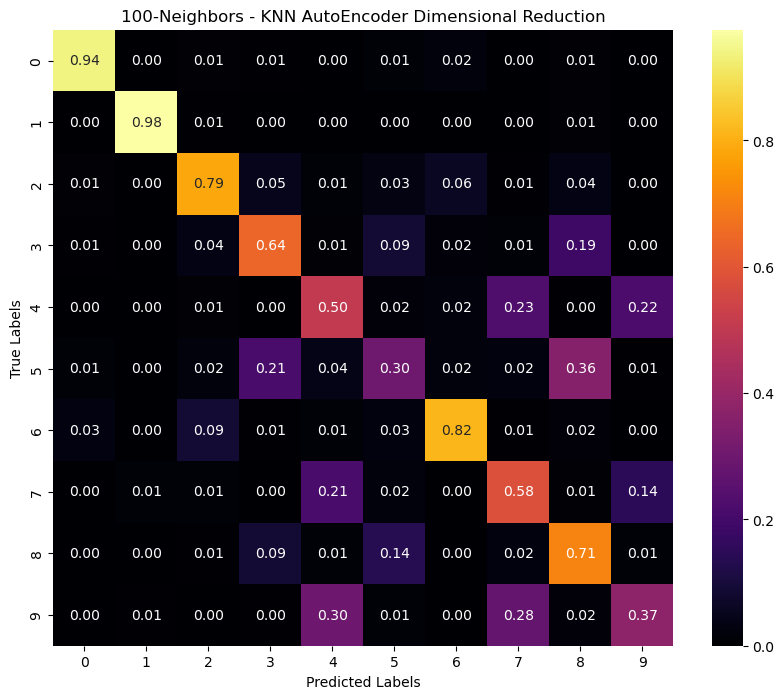

,k,Accuracy,Test Error
0,1,0.5790,0.4210
1,2,0.5801,0.4199
2,5,0.6354,0.3646
3,10,0.6464,0.3536
4,100,0.6698,0.3302


In [13]:
k_values_ae = []
accuracy_list_ae = []
error_list_ae = []

for k in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_ae, y_train)
    pred_y_ae = knn.predict(x_test_ae)

    # Calculate accuracy and test error
    accuracy = np.mean(pred_y_ae == y_test)
    test_error = 1 - accuracy

    k_values_ae.append(k)
    accuracy_list_ae.append(accuracy)
    error_list_ae.append(test_error)

    # Calculate the normalized confusion matrix
    cm_ae = confusion_matrix(y_test, pred_y_ae)
    cm_normalized_ae = cm_ae.astype('float') / cm_ae.sum(axis=1)[:, np.newaxis]
    
    # Plotting the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_normalized_ae, annot=True, fmt=".2f", cmap="inferno")
    plt.title(f'{k}-Neighbors - KNN AutoEncoder Dimensional Reduction')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# turn results to DF
results_df = pd.DataFrame({
    'k': k_values_ae,
    'Accuracy': accuracy_list_ae,
    'Test Error': error_list_ae
})

results_df